<a href="https://colab.research.google.com/github/apriandito/nowcasting/blob/main/08_nowcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nowcasting

**Tujuan**: Memprediksi nilai periode saat ini yang belum diketahui menggunakan data frekuensi tinggi yang sudah tersedia

**Method**:
- Machine Learning Models
- Walk-Forward Validation
- Explainable AI (SHAP)

## 1. Import Libraries

In [ ]:
# Uncomment dan jalankan jika library belum terinstall
# !pip install shap plotly scikit-learn pandas numpy matplotlib

## 0. Install Required Libraries (if needed)

Jalankan cell di bawah jika ada library yang belum terinstall

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go
import shap
import matplotlib.pyplot as plt

## 2. Load Data

In [ ]:
# Load data
df = pd.read_csv('data_nowcasting.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

print(f"Data shape: {df.shape}")
print(f"Periode: {df['Date'].min()} - {df['Date'].max()}")
df.tail()

Data shape: (58, 10)
Periode: 2020-01-01 00:00:00 - 2024-10-01 00:00:00


,Date,Quarter,GDP_Growth,Sukuk_Issuance,Islamic_Banking_Asset,Zakat_Collection,Inflation,Islamic_Stock_Index,Gold_Price,Mudharabah_Rate
53,2024-06-01,2024-Q2,5.342630,75.4,652.5,11.0,3.38,960.2,1213510,6.78
54,2024-07-01,2024-Q3,4.597615,76.5,657.0,11.2,3.30,971.0,1228684,6.61
55,2024-08-01,2024-Q3,4.555695,78.6,659.7,11.2,2.92,986.8,1233776,6.71
56,2024-09-01,2024-Q3,4.177681,79.7,667.9,11.5,2.83,987.4,1241745,6.79
57,2024-10-01,2024-Q4,NaN,80.2,664.8,11.7,2.26,983.3,1245474,6.88


In [ ]:
# Cek data terakhir (nowcasting target)
print("Data terakhir (Q4 2024):")
df.tail()

Data terakhir (Q4 2024):


,Date,Quarter,GDP_Growth,Sukuk_Issuance,Islamic_Banking_Asset,Zakat_Collection,Inflation,Islamic_Stock_Index,Gold_Price,Mudharabah_Rate
53,2024-06-01,2024-Q2,5.342630,75.4,652.5,11.0,3.38,960.2,1213510,6.78
54,2024-07-01,2024-Q3,4.597615,76.5,657.0,11.2,3.30,971.0,1228684,6.61
55,2024-08-01,2024-Q3,4.555695,78.6,659.7,11.2,2.92,986.8,1233776,6.71
56,2024-09-01,2024-Q3,4.177681,79.7,667.9,11.5,2.83,987.4,1241745,6.79
57,2024-10-01,2024-Q4,NaN,80.2,664.8,11.7,2.26,983.3,1245474,6.88


## 3. Feature Engineering

In [ ]:
# Buat salinan untuk feature engineering
df_feat = df.copy()

# Lag features untuk variabel leading indicators
df_feat['Sukuk_lag1'] = df_feat['Sukuk_Issuance'].shift(1)
df_feat['Banking_lag1'] = df_feat['Islamic_Banking_Asset'].shift(1)
df_feat['Zakat_lag1'] = df_feat['Zakat_Collection'].shift(1)

# Moving averages
df_feat['Sukuk_MA3'] = df_feat['Sukuk_Issuance'].shift(1).rolling(window=3).mean()
df_feat['Banking_MA3'] = df_feat['Islamic_Banking_Asset'].shift(1).rolling(window=3).mean()

# Rate of change
df_feat['Sukuk_ROC'] = df_feat['Sukuk_Issuance'].shift(1).pct_change()
df_feat['Banking_ROC'] = df_feat['Islamic_Banking_Asset'].shift(1).pct_change()

# Standard deviation (volatility)
df_feat['Inflation_STD3'] = df_feat['Inflation'].shift(1).rolling(window=3).std()
df_feat['StockIndex_STD3'] = df_feat['Islamic_Stock_Index'].shift(1).rolling(window=3).std()

# Momentum
df_feat['Sukuk_Momentum'] = df_feat['Sukuk_Issuance'].shift(1) - df_feat['Sukuk_Issuance'].shift(2)
df_feat['Banking_Momentum'] = df_feat['Islamic_Banking_Asset'].shift(1) - df_feat['Islamic_Banking_Asset'].shift(2)

print(f"Shape sebelum dropna: {df_feat.shape}")
print(f"Missing values per column:")
print(df_feat.isnull().sum()[df_feat.isnull().sum() > 0])

# IMPORTANT: Pisahkan nowcasting row SEBELUM dropna
df_nowcast_raw = df_feat[df_feat['GDP_Growth'].isna()].copy()

# Hapus missing values untuk training data
df_feat_clean = df_feat.dropna()

print(f"\nShape setelah dropna: {df_feat_clean.shape}")
print(f"Nowcasting data (before cleaning): {len(df_nowcast_raw)} rows")
df_feat_clean.head()

Shape sebelum dropna: (58, 21)
Missing values per column:
GDP_Growth          1
Sukuk_lag1          1
Banking_lag1        1
Zakat_lag1          1
Sukuk_MA3           3
Banking_MA3         3
Sukuk_ROC           2
Banking_ROC         2
Inflation_STD3      3
StockIndex_STD3     3
Sukuk_Momentum      2
Banking_Momentum    2
dtype: int64

Shape setelah dropna: (54, 21)
Nowcasting data (before cleaning): 1 rows


,Date,Quarter,GDP_Growth,Sukuk_Issuance,Islamic_Banking_Asset,Zakat_Collection,Inflation,Islamic_Stock_Index,Gold_Price,Mudharabah_Rate,...,Banking_lag1,Zakat_lag1,Sukuk_MA3,Banking_MA3,Sukuk_ROC,Banking_ROC,Inflation_STD3,StockIndex_STD3,Sukuk_Momentum,Banking_Momentum
3,2020-04-01,2020-Q2,5.088332,16.5,460.1,2.5,3.75,606.2,774624,4.49,...,457.3,2.3,12.733333,453.800000,0.120968,0.001533,0.518588,13.108903,1.5,0.7
4,2020-05-01,2020-Q2,5.051373,16.9,464.7,2.5,3.58,606.8,787768,4.56,...,460.1,2.5,14.266667,458.000000,0.187050,0.006123,0.280238,11.888790,2.6,2.8
5,2020-06-01,2020-Q2,5.152733,18.1,466.2,2.9,3.90,612.8,796477,4.78,...,464.7,2.5,15.766667,460.700000,0.024242,0.009998,0.276104,3.017173,0.4,4.6
6,2020-07-01,2020-Q3,4.524689,19.1,472.1,3.1,3.84,632.4,799411,4.59,...,466.2,2.9,17.166667,463.666667,0.071006,0.003228,0.160104,3.649658,1.2,1.5
7,2020-08-01,2020-Q3,4.732204,20.5,478.8,3.1,4.57,625.9,815503,4.91,...,472.1,3.1,18.033333,467.666667,0.055249,0.012656,0.170098,13.388552,1.0,5.9


### 3.1 Correlation Analysis

In [ ]:
# Correlation dengan GDP Growth
import plotly.figure_factory as ff

# Pilih kolom numerik untuk correlation
numeric_cols = df_feat_clean.select_dtypes(include=[np.number]).columns.tolist()

# Hitung correlation matrix
corr_matrix = df_feat_clean[numeric_cols].corr()

# Sort berdasarkan korelasi dengan GDP_Growth (absolute value)
gdp_corr = corr_matrix['GDP_Growth'].drop('GDP_Growth')  # Drop self-correlation
gdp_corr_abs = gdp_corr.abs().sort_values(ascending=False)

# Ambil top 10 berdasarkan absolute correlation
top_10_features = gdp_corr_abs.head(10).index.tolist()
top_10_corr = gdp_corr[top_10_features].sort_values()  # Sort untuk visualisasi

print(f"Computed correlation for {len(numeric_cols)} features")
print(f"Top 10 features selected based on absolute correlation")

Computed correlation for 19 features
Top 10 features selected based on absolute correlation


In [ ]:
# Visualisasi correlation heatmap (Top 10 features)
# Subset correlation matrix untuk top 10 features
corr_subset = corr_matrix.loc[top_10_features + ['GDP_Growth'], top_10_features + ['GDP_Growth']]

# Plotly heatmap
fig = ff.create_annotated_heatmap(
    z=corr_subset.values,
    x=corr_subset.columns.tolist(),
    y=corr_subset.columns.tolist(),
    annotation_text=np.round(corr_subset.values, 2),
    colorscale='RdBu',
    zmid=0,
    showscale=True
)

fig.update_layout(
    title='Correlation Matrix - Top 10 Features (by absolute correlation with GDP Growth)',
    xaxis={'side': 'bottom'},
    width=900,
    height=800,
    font=dict(size=10)
)

# Rotate x-axis labels
fig.update_xaxes(tickangle=-45)

fig.show()

In [ ]:
# Bar plot: Top 10 Correlation dengan GDP Growth
fig = go.Figure()

# Color berdasarkan positive/negative
colors = ['green' if x > 0 else 'red' for x in top_10_corr.values]

fig.add_trace(go.Bar(
    y=top_10_corr.index,
    x=top_10_corr.values,
    orientation='h',
    marker=dict(color=colors),
    text=np.round(top_10_corr.values, 3),
    textposition='auto'
))

fig.update_layout(
    title='Top 10 Feature Correlation dengan GDP Growth',
    xaxis_title='Correlation Coefficient',
    yaxis_title='Features',
    template='plotly_white',
    width=900,
    height=600,
    showlegend=False
)

fig.show()

# Print top 10 correlations
print("\nTop 10 features dengan korelasi tertinggi terhadap GDP Growth:")
print("="*70)
for i, (feature, corr_value) in enumerate(top_10_corr.sort_values(key=abs, ascending=False).items(), 1):
    print(f"{i:2d}. {feature:25s} : {corr_value:+.4f}")
print("="*70)


Top 10 features dengan korelasi tertinggi terhadap GDP Growth:
 1. Sukuk_Momentum            : -0.2454
 2. Inflation_STD3            : -0.2077
 3. Banking_ROC               : -0.1874
 4. Banking_Momentum          : -0.1807
 5. Inflation                 : +0.1076
 6. Sukuk_ROC                 : -0.0951
 7. StockIndex_STD3           : -0.0819
 8. Sukuk_lag1                : -0.0355
 9. Banking_lag1              : -0.0342
10. Islamic_Stock_Index       : -0.0333


## 4. Prepare Features and Target

In [ ]:
# Feature columns
feature_cols = [
    'Sukuk_Issuance', 'Islamic_Banking_Asset', 'Zakat_Collection',
    'Inflation', 'Islamic_Stock_Index', 'Gold_Price', 'Mudharabah_Rate',
    'Sukuk_lag1', 'Banking_lag1', 'Zakat_lag1',
    'Sukuk_MA3', 'Banking_MA3',
    'Sukuk_ROC', 'Banking_ROC',
    'Inflation_STD3', 'StockIndex_STD3',
    'Sukuk_Momentum', 'Banking_Momentum'
]

# Prepare training data (data yang GDP-nya ada dan sudah clean)
X = df_feat_clean[feature_cols]
y = df_feat_clean['GDP_Growth']

# Prepare nowcasting data
print(f"\nNowcasting raw data: {len(df_nowcast_raw)} rows")
if len(df_nowcast_raw) > 0:
    print("Nowcasting data info:")
    print(f"  Quarter: {df_nowcast_raw['Quarter'].values}")
    print(f"  Date: {df_nowcast_raw['Date'].values}")
    print(f"  Missing features: {df_nowcast_raw[feature_cols].isna().sum().sum()}")

# Fill missing features dengan forward fill dari data terakhir yang valid
df_nowcast = df_nowcast_raw.copy()

# Ambil nilai terakhir dari training data untuk fill missing
last_valid_row = df_feat_clean.iloc[-1]

for col in feature_cols:
    if col in df_nowcast.columns and df_nowcast[col].isna().any():
        # Fill dengan nilai dari last valid row
        df_nowcast[col] = df_nowcast[col].fillna(last_valid_row[col])

X_nowcast = df_nowcast[feature_cols]

print(f"\nTraining data:")
print(f"  Features: {len(feature_cols)}")
print(f"  Samples: {len(X)}")
print(f"\nNowcasting data (after fill):")
print(f"  Samples: {len(X_nowcast)}")
print(f"  Missing values: {X_nowcast.isna().sum().sum()}")

if len(X_nowcast) > 0:
    print(f"\nNowcasting features preview:")
    print(X_nowcast.head())


Nowcasting raw data: 1 rows
Nowcasting data info:
  Quarter: ['2024-Q4']
  Date: ['2024-10-01T00:00:00.000000000']
  Missing features: 0

Training data:
  Features: 18
  Samples: 54

Nowcasting data (after fill):
  Samples: 1
  Missing values: 0

Nowcasting features preview:
    Sukuk_Issuance  Islamic_Banking_Asset  Zakat_Collection  Inflation  \
57            80.2                  664.8              11.7       2.26   

    Islamic_Stock_Index  Gold_Price  Mudharabah_Rate  Sukuk_lag1  \
57                983.3     1245474             6.88        79.7   

    Banking_lag1  Zakat_lag1  Sukuk_MA3  Banking_MA3  Sukuk_ROC  Banking_ROC  \
57         667.9        11.5  78.266667   661.533333   0.013995      0.01243   

    Inflation_STD3  StockIndex_STD3  Sukuk_Momentum  Banking_Momentum  
57        0.249466         9.300179             1.1               8.2  


## 5. Define Models

In [ ]:
# Daftar model
models = {
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01, max_iter=5000),
    'BayesianRidge': BayesianRidge(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

print("Models:")
for i, name in enumerate(models.keys(), 1):
    print(f"  {i}. {name}")

Models:
  1. ElasticNet
  2. LinearRegression
  3. Ridge
  4. Lasso
  5. BayesianRidge
  6. RandomForest
  7. GradientBoosting


## 6. Walk-Forward Validation

In [ ]:
# Walk-forward validation
validation_results = []
start_index = 12  # Minimal 4 quarters untuk training

print(f"Walk-forward validation: {len(X) - start_index} iterations\n")

for t in range(start_index, len(X)):
    X_train, y_train = X.iloc[:t], y.iloc[:t]
    X_test, y_test_point = X.iloc[t:t+1], y.iloc[t:t+1]

    result = {
        'Date': y_test_point.index[0],
        'Actual': y_test_point.values[0]
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]
        result[f'{name}_Pred'] = y_pred
        result[f'{name}_AbsErr'] = abs(y_pred - y_test_point.values[0])

    validation_results.append(result)

# Simpan hasil ke DataFrame
val_df = pd.DataFrame(validation_results)

print(f"Validation complete: {len(val_df)} predictions")
val_df.head()

Walk-forward validation: 42 iterations

Validation complete: 42 predictions


,Date,Actual,ElasticNet_Pred,ElasticNet_AbsErr,LinearRegression_Pred,LinearRegression_AbsErr,Ridge_Pred,Ridge_AbsErr,Lasso_Pred,Lasso_AbsErr,BayesianRidge_Pred,BayesianRidge_AbsErr,RandomForest_Pred,RandomForest_AbsErr,GradientBoosting_Pred,GradientBoosting_AbsErr
0,15,5.272121,5.014587,0.257534,5.606832,0.334711,5.440115,0.167994,5.372370,0.100249,4.877225,0.394896,4.931171,0.340950,4.982790,0.289331
1,16,4.877026,4.719751,0.157275,3.843744,1.033282,4.629353,0.247673,4.583053,0.293973,4.989173,0.112147,4.898754,0.021727,4.958537,0.081511
2,17,5.198426,4.635815,0.562611,3.707556,1.490871,4.489468,0.708958,4.444301,0.754125,4.965773,0.232653,4.806871,0.391555,4.731824,0.466602
3,18,4.656296,5.109806,0.453511,5.175032,0.518736,5.104476,0.448180,4.939818,0.283522,5.033313,0.377017,5.011532,0.355236,5.000087,0.343791
4,19,4.634248,4.968031,0.333782,4.129530,0.504719,5.100361,0.466113,5.173917,0.539669,4.949867,0.315619,5.157778,0.523530,5.210767,0.576519


## 7. Model Evaluation

In [ ]:
# Function untuk menghitung Directional Accuracy
def directional_accuracy(y_true, y_pred):
    """
    Menghitung persentase prediksi yang benar arahnya (naik/turun)
    """
    if len(y_true) < 2:
        return np.nan

    # Hitung perubahan actual dan predicted
    actual_direction = np.diff(y_true) > 0
    pred_direction = np.diff(y_pred) > 0

    # Hitung akurasi arah
    correct_direction = actual_direction == pred_direction
    da = np.mean(correct_direction) * 100

    return da

# Evaluasi akurasi model
metrics = []
for name in models.keys():
    y_true = val_df['Actual'].values
    y_pred = val_df[f'{name}_Pred'].values

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    da = directional_accuracy(y_true, y_pred)

    metrics.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'DA': da  # Directional Accuracy
    })

# Hasil evaluasi
results_df = pd.DataFrame(metrics)
results_df = results_df.sort_values('RMSE')
print("Model Performance Metrics:")
print("="*80)
results_df.round(4)

Model Performance Metrics:


,Model,MAE,RMSE,MAPE,R2,DA
4,BayesianRidge,0.2949,0.3598,6.1360,-0.1490,31.7073
0,ElasticNet,0.3099,0.3825,6.4444,-0.2990,48.7805
5,RandomForest,0.3375,0.4063,7.0321,-0.4654,43.9024
6,GradientBoosting,0.3398,0.4208,7.0959,-0.5723,46.3415
3,Lasso,0.3743,0.4476,7.7431,-0.7789,48.7805
2,Ridge,0.3938,0.4615,8.1504,-0.8911,46.3415
1,LinearRegression,0.7480,1.1463,15.5980,-10.6647,53.6585


## 8. Visualisasi Prediksi (Interactive)

In [ ]:
# Visualisasi prediksi semua model
predictions = {name: val_df[f'{name}_Pred'].values for name in models.keys()}
y_test = val_df['Actual']

# Plotly interactive graph
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=val_df['Date'],
    y=y_test,
    mode='lines+markers',
    name='Actual',
    line=dict(width=2, color='black'),
    visible=True
))

for i, (name, y_pred) in enumerate(predictions.items()):
    fig.add_trace(go.Scatter(
        x=val_df['Date'],
        y=y_pred,
        mode='lines+markers',
        name=f'Predicted - {name}',
        line=dict(width=2),
        visible=(i == 0)
    ))

dropdown_buttons = []
n_models = len(predictions)
for i, name in enumerate(predictions.keys()):
    visibility = [True] + [j == i for j in range(n_models)]
    dropdown_buttons.append(dict(
        label=name,
        method='update',
        args=[
            {'visible': visibility},
            {'title': f'{name} - GDP Growth Nowcasting (Walk-Forward)'}
        ]
    ))

fig.update_layout(
    title='GDP Growth Nowcasting (Walk-Forward Validation)',
    xaxis_title='Date',
    yaxis_title='GDP Growth (%)',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    width=1200,
    height=600,
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction="down",
        showactive=True,
        x=1.15,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )]
)
fig.show()

## 9. Nowcasting GDP Q4 2024

In [ ]:
# Pilih model terbaik
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"RMSE: {results_df.iloc[0]['RMSE']:.4f}")
print(f"MAPE: {results_df.iloc[0]['MAPE']:.2f}%")
print(f"Directional Accuracy: {results_df.iloc[0]['DA']:.2f}%")

Best Model: BayesianRidge
RMSE: 0.3598
MAPE: 6.14%
Directional Accuracy: 31.71%


In [ ]:
# Train dengan semua data
best_model.fit(X, y)

print("Data untuk nowcasting Q4 2024:")
print(f"Samples: {len(X_nowcast)}")

if len(X_nowcast) > 0:
    print(f"\nFeature values:")
    display(X_nowcast)  # Display the dataframe
else:
    print("Tidak ada data untuk nowcasting")

Data untuk nowcasting Q4 2024:
Samples: 1

Feature values:


,Sukuk_Issuance,Islamic_Banking_Asset,Zakat_Collection,Inflation,Islamic_Stock_Index,Gold_Price,Mudharabah_Rate,Sukuk_lag1,Banking_lag1,Zakat_lag1,Sukuk_MA3,Banking_MA3,Sukuk_ROC,Banking_ROC,Inflation_STD3,StockIndex_STD3,Sukuk_Momentum,Banking_Momentum
57,80.2,664.8,11.7,2.26,983.3,1245474,6.88,79.7,667.9,11.5,78.266667,661.533333,0.013995,0.01243,0.249466,9.300179,1.1,8.2


In [ ]:
# Nowcasting GDP Q4 2024
if len(X_nowcast) > 0:
    gdp_nowcast = best_model.predict(X_nowcast)[0]

    print("\n" + "="*60)
    print("NOWCASTING GDP GROWTH Q4 2024")
    print("="*60)
    print(f"Model         : {best_model_name}")
    print(f"Quarter       : Q4 2024")
    print(f"Nowcast Value : {gdp_nowcast:.2f}%")
    print("="*60)

    # Prediksi dari semua model
    print("\nNowcast dari semua model:")
    for name, model in models.items():
        model.fit(X, y)
        pred = model.predict(X_nowcast)[0]
        print(f"  {name:20s}: {pred:.2f}%")
else:
    print("Tidak ada data untuk nowcasting")


NOWCASTING GDP GROWTH Q4 2024
Model         : BayesianRidge
Quarter       : Q4 2024
Nowcast Value : 4.88%

Nowcast dari semua model:
  ElasticNet          : 4.82%
  LinearRegression    : 5.01%
  Ridge               : 4.83%
  Lasso               : 4.81%
  BayesianRidge       : 4.88%
  RandomForest        : 4.83%
  GradientBoosting    : 4.44%


## 10. SHAP Analysis (XAI)

In [ ]:
# SHAP Explainer
# Pilih explainer berdasarkan jenis model
if best_model_name in ['ElasticNet', 'LinearRegression', 'Ridge', 'Lasso', 'BayesianRidge']:
    # Untuk linear models, gunakan LinearExplainer
    explainer = shap.LinearExplainer(best_model, X)
    shap_values = explainer.shap_values(X)
else:
    # Untuk tree-based models (RandomForest, GradientBoosting)
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X)

print(f"SHAP explainer created for {best_model_name}")
print(f"SHAP values shape: {shap_values.shape if hasattr(shap_values, 'shape') else 'N/A'}")

SHAP explainer created for BayesianRidge
SHAP values shape: (54, 18)


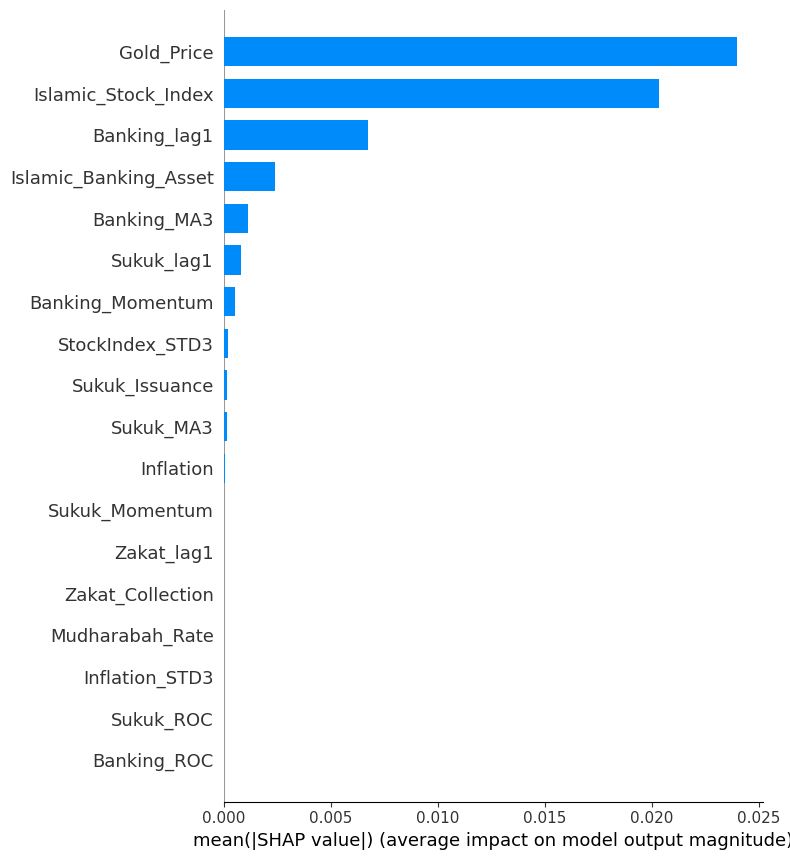

In [ ]:
# Global feature importance
if best_model_name in ['ElasticNet', 'LinearRegression', 'Ridge', 'Lasso', 'BayesianRidge']:
    shap.summary_plot(shap_values, X, plot_type="bar")
else:
    shap.summary_plot(shap_values, plot_type="bar")

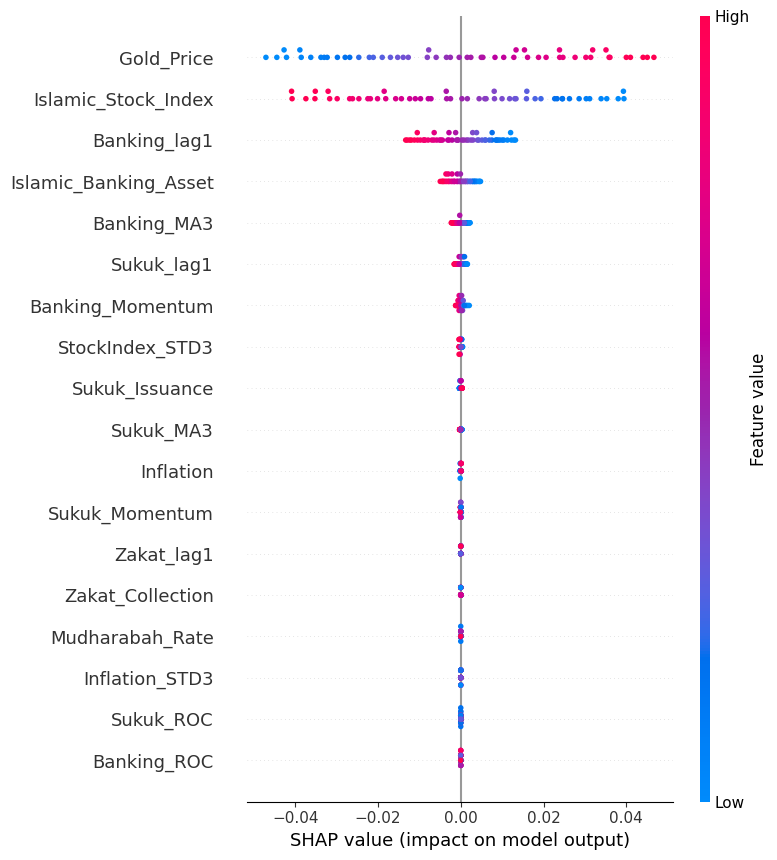

In [ ]:
# SHAP beeswarm plot
if best_model_name in ['ElasticNet', 'LinearRegression', 'Ridge', 'Lasso', 'BayesianRidge']:
    shap.summary_plot(shap_values, X)
else:
    shap.summary_plot(shap_values)

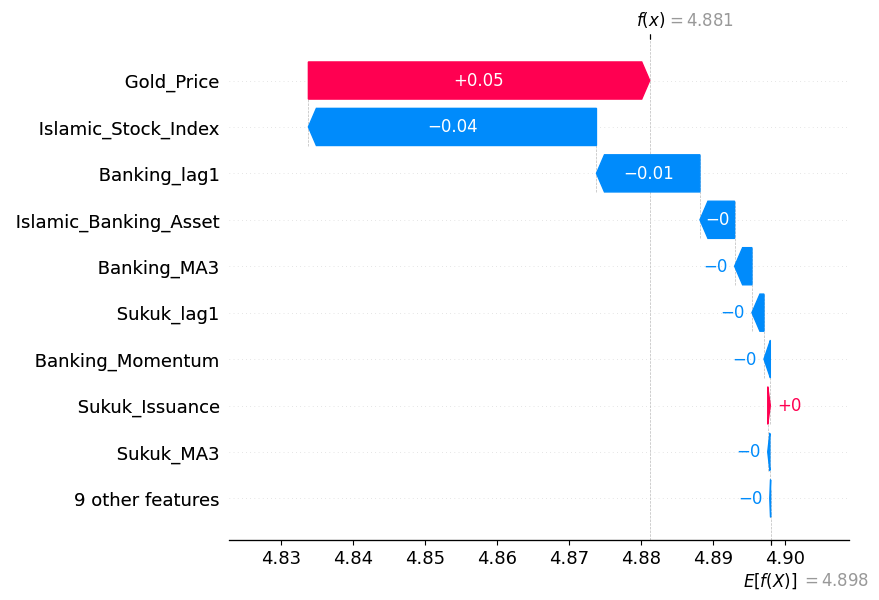

In [ ]:
# SHAP waterfall untuk nowcasting
if len(X_nowcast) > 0:
    if best_model_name in ['ElasticNet', 'LinearRegression', 'Ridge', 'Lasso', 'BayesianRidge']:
        shap_nowcast = explainer.shap_values(X_nowcast)
        shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_nowcast[0], X_nowcast.iloc[0])
    else:
        shap_nowcast = explainer(X_nowcast)
        shap.plots.waterfall(shap_nowcast[0], max_display=20)